In [1]:
import os
import json
import time
from datetime import date, timedelta
from pathlib import Path
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Lumina Core Factors
### Market Cap Factor: Reward larger companies relative to others in their sector.
### Volatility Factor: Reward lower-volatility companies, as calculate by st dev of returns



In [2]:
class LuminaCoreEngine:
    """
    Unified Lumina Core system that combines caching and quality scoring
    One class to rule them all!
    """
    
    def __init__(self, client, cache_dir="lumina_cache"):
        self.client = client
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        
        # Cache file paths
        self.market_cap_cache = self.cache_dir / "market_cap_cache.json"
        self.volatility_cache = self.cache_dir / "volatility_cache.json"
        self.sp500_cache = self.cache_dir / "sp500_constituents.json"
        self.portfolio_cache = self.cache_dir / "lumina_portfolio.json"
        
        # Cache expiry settings (days)
        self.market_cap_expiry = 7
        self.volatility_expiry = 1  
        self.sp500_expiry = 30
        self.portfolio_expiry = 1  # Portfolio gets rebuilt daily
        
        # Quality scoring weights
        self.quality_weights = {
            'market_cap': 45,
            'volatility': 40,
            'liquidity': 0,
            'sector_balance': 15
        }
    
    def generate_lumina_portfolio(self, target_stocks=300, min_quality=60, force_refresh=False):
        """
        Main method: Generate complete Lumina Core portfolio
        Handles caching, data fetching, scoring, and selection
        """
        print("🚀 GENERATING LUMINA CORE PORTFOLIO")
        print("=" * 50)
        
        # Check if we have a valid cached portfolio
        if not force_refresh and self._is_cache_valid(self.portfolio_cache, self.portfolio_expiry):
            print("✅ Loading cached Lumina portfolio...")
            cached_portfolio = self._load_portfolio_cache()
            if cached_portfolio is not None:
                self._display_portfolio_summary(cached_portfolio)
                return cached_portfolio
        
        print("🔄 Building fresh Lumina portfolio...")
        
        # Step 1: Get base S&P 500 data with caching
        sp500_df = self._get_sp500_constituents(force_refresh)
        
        # Step 2: Enrich with market data (cached)
        enriched_df = self._enrich_with_market_data(sp500_df, force_refresh)
        
        # Step 3: Apply initial screens
        filtered_df = self._apply_initial_screens(enriched_df)
        
        # Step 4: Calculate quality scores
        scored_df = self._calculate_quality_scores(filtered_df)
        
        # Step 5: Select final portfolio
        final_portfolio = self._select_final_portfolio(scored_df, target_stocks, min_quality)
        
        # Step 6: Cache the result
        self._save_portfolio_cache(final_portfolio)
        
        # Step 7: Display summary
        self._display_portfolio_summary(final_portfolio)
        
        return final_portfolio
    
    def _get_sp500_constituents(self, force_refresh=False):
        """Get S&P 500 constituents with caching"""
        if force_refresh or not self._is_cache_valid(self.sp500_cache, self.sp500_expiry):
            print("📋 Fetching fresh S&P 500 constituents...")
            url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
            sp500_df = pd.read_csv(url)
            self._save_cache(self.sp500_cache, sp500_df.to_dict('records'))
            return sp500_df
        else:
            print("✅ Loading S&P 500 constituents from cache")
            cached_data, _ = self._load_cache(self.sp500_cache)
            return pd.DataFrame(cached_data)
    
    def _enrich_with_market_data(self, df, force_refresh=False):
        """Add market cap, volatility, and other market data"""
        print("💰 Enriching with market data...")
        
        tickers = df['Symbol'].tolist()
        
        # Get market cap data (cached)
        market_cap_data = self._get_market_cap_batch(tickers, force_refresh)
        df['market_cap'] = df['Symbol'].map(market_cap_data)
        df = df.dropna(subset=['market_cap'])
        
        # Calculate sector weights
        total_market_cap = df['market_cap'].sum()
        df['weight'] = df['market_cap'] / total_market_cap
        
        # Add sector analysis
        sector_weights = df.groupby('GICS Sector').agg({'market_cap': 'sum'}).reset_index()
        sector_weights['sector_weight'] = sector_weights['market_cap'] / total_market_cap
        ticker_counts = df.groupby('GICS Sector')['Symbol'].count().reset_index()
        ticker_counts.rename(columns={'Symbol': 'sector_ticker_count'}, inplace=True)
        sector_weights = pd.merge(sector_weights, ticker_counts, on='GICS Sector')
        
        # Merge back to main dataframe
        df = pd.merge(df, sector_weights, on='GICS Sector', suffixes=('', '_sector'))
        
        return df
    
    def _apply_initial_screens(self, df):
        """Apply initial market cap and other basic screens"""
        print("🔍 Applying initial screens...")
        
        # Market cap screen: remove bottom 20% by sector
        filtered_list = []
        for sector, group in df.groupby("GICS Sector"):
            group = group.sort_values("market_cap", ascending=False).reset_index(drop=True)
            cutoff = int(len(group) * 0.2)
            trimmed_group = group.iloc[:-cutoff] if cutoff > 0 else group
            filtered_list.append(trimmed_group)
        
        filtered_df = pd.concat(filtered_list).reset_index(drop=True)
        
        # Get volatility data for filtered stocks
        filtered_tickers = filtered_df['Symbol'].tolist()
        volatility_data = self._get_volatility_batch(filtered_tickers, False)
        filtered_df['volatility'] = filtered_df['Symbol'].map(volatility_data)
        
        print(f"📊 After initial screens: {len(filtered_df)} stocks (from {len(df)})")
        return filtered_df
    
    def _calculate_quality_scores(self, df):
        """Calculate quality scores for all stocks"""
        print("🎯 Calculating quality scores...")
        df = df.copy()
        
        # Market Cap Score (sector-relative)
        df['mcap_sector_rank'] = df.groupby('GICS Sector')['market_cap'].rank(pct=True)
        df['mcap_score'] = df['mcap_sector_rank'] * self.quality_weights['market_cap']
        
        # Volatility Score (lower = better)
        df['vol_rank'] = df['volatility'].rank(pct=True, ascending=False)
        df['vol_score'] = df['vol_rank'] * self.quality_weights['volatility']
        
        # Liquidity Score (using market cap as proxy)
        df['liquidity_score'] = df['mcap_sector_rank'] * self.quality_weights['liquidity']
        
        # Sector Balance Score
        df['sector_balance_score'] = self._calculate_sector_balance_score(df)
        
        # Total Quality Score
        df['quality_score'] = (
            df['mcap_score'] + df['vol_score'] + 
            df['liquidity_score'] + df['sector_balance_score']
        )
        
        # Quality Tiers
        df['quality_tier'] = pd.cut(
            df['quality_score'], 
            bins=[0, 60, 75, 85, 100], 
            labels=['Bronze', 'Silver', 'Gold', 'Platinum'],
            include_lowest=True
        )
        
        return df
    
    def _calculate_sector_balance_score(self, df):
        """Calculate sector diversification bonus"""
        total_market_cap = df['market_cap'].sum()
        sector_weights = df.groupby('GICS Sector')['market_cap'].sum() / total_market_cap
        
        n_sectors = df['GICS Sector'].nunique()
        target_weight = 1 / n_sectors
        
        sector_bonuses = {}
        for sector in df['GICS Sector'].unique():
            current_weight = sector_weights[sector]
            weight_diff = target_weight - current_weight
            bonus = max(0, weight_diff * 100)
            sector_bonuses[sector] = min(bonus, self.quality_weights['sector_balance'])
        
        return df['GICS Sector'].map(sector_bonuses)
    
    def _select_final_portfolio(self, df, target_stocks, min_quality):
        """Select final portfolio using quality scores"""
        print(f"🏆 Selecting top {target_stocks} stocks...")
        
        # Quality filter
        quality_filtered = df[df['quality_score'] >= min_quality].copy()
        
        if len(quality_filtered) < target_stocks:
            target_stocks = len(quality_filtered)
            print(f"⚠️ Adjusted target to {target_stocks} stocks due to quality threshold")
        
        # Sector-balanced selection
        sectors = quality_filtered['GICS Sector'].unique()
        sector_selections = []
        total_market_cap = quality_filtered['market_cap'].sum()
        
        for sector in sectors:
            sector_df = quality_filtered[quality_filtered['GICS Sector'] == sector]
            sector_weight = sector_df['market_cap'].sum() / total_market_cap
            
            target_sector_stocks = max(1, min(
                int(target_stocks * sector_weight * 1.2),
                int(target_stocks * 0.30)
            ))
            
            sector_top = sector_df.nlargest(target_sector_stocks, 'quality_score')
            sector_selections.append(sector_top)
        
        # Combine and finalize
        portfolio = pd.concat(sector_selections, ignore_index=True)
        
        # Adjust to exact target size
        if len(portfolio) > target_stocks:
            portfolio = portfolio.nlargest(target_stocks, 'quality_score')
        elif len(portfolio) < target_stocks:
            remaining = quality_filtered[~quality_filtered['Symbol'].isin(portfolio['Symbol'])]
            additional = remaining.nlargest(target_stocks - len(portfolio), 'quality_score')
            portfolio = pd.concat([portfolio, additional], ignore_index=True)
        
        return portfolio.sort_values('quality_score', ascending=False).reset_index(drop=True)
    
    def _display_portfolio_summary(self, portfolio):
        """Display comprehensive portfolio analysis"""
        print(f"\n✅ LUMINA CORE PORTFOLIO SUMMARY")
        print("=" * 50)
        print(f"📊 Total Stocks: {len(portfolio)}")
        print(f"🏆 Avg Quality Score: {portfolio['quality_score'].mean():.1f}/100")
        
        # Quality distribution
        tier_counts = portfolio['quality_tier'].value_counts()
        print(f"\n🥇 Quality Distribution:")
        for tier in ['Platinum', 'Gold', 'Silver', 'Bronze']:
            if tier in tier_counts:
                count = tier_counts[tier]
                pct = count / len(portfolio) * 100
                print(f"   {tier}: {count} stocks ({pct:.1f}%)")
        
        # Sector distribution
        print(f"\n🏭 Sector Allocation:")
        sector_summary = portfolio.groupby('GICS Sector').agg({
            'Symbol': 'count',
            'market_cap': 'sum'
        })
        sector_summary['weight'] = sector_summary['market_cap'] / sector_summary['market_cap'].sum()
        sector_summary = sector_summary.sort_values('weight', ascending=False)
        
        for sector, row in sector_summary.iterrows():
            print(f"   {sector}: {row['Symbol']} stocks ({row['weight']:.1%})")
    
    # Cache management methods (same as before but integrated)
    def _is_cache_valid(self, cache_file, expiry_days):
        if not cache_file.exists():
            return False
        file_age = time.time() - cache_file.stat().st_mtime
        return file_age < (expiry_days * 24 * 60 * 60)
    
    def _load_cache(self, cache_file):
        try:
            with open(cache_file, 'r') as f:
                data = json.load(f)
                return data.get('data', {}), data.get('timestamp')
        except (FileNotFoundError, json.JSONDecodeError):
            return {}, None
    
    def _save_cache(self, cache_file, data):
        cache_data = {
            'data': data,
            'timestamp': time.time(),
            'date': date.today().isoformat()
        }
        with open(cache_file, 'w') as f:
            json.dump(cache_data, f, indent=2)
    
    def _get_market_cap_batch(self, tickers, force_refresh):
        """Market cap with caching (same logic as before)"""
        cached_data, _ = self._load_cache(self.market_cap_cache)
        
        if force_refresh or not self._is_cache_valid(self.market_cap_cache, self.market_cap_expiry):
            cached_data = {}
        
        missing_tickers = [t for t in tickers if t not in cached_data]
        
        if missing_tickers:
            print(f"📈 Fetching market cap for {len(missing_tickers)} tickers...")
            for ticker in tqdm(missing_tickers, desc="Market cap"):
                try:
                    market_cap = self.client.get_ticker_details(ticker).market_cap
                    cached_data[ticker] = market_cap
                    time.sleep(0.5)
                except Exception as e:
                    print(f"❌ {ticker} failed: {e}")
                    cached_data[ticker] = None
            self._save_cache(self.market_cap_cache, cached_data)
        
        return cached_data
    
    def _get_volatility_batch(self, tickers, force_refresh):
        """Volatility with caching (same logic as before)"""
        cached_data, _ = self._load_cache(self.volatility_cache)
        
        if force_refresh or not self._is_cache_valid(self.volatility_cache, self.volatility_expiry):
            cached_data = {}
        
        missing_tickers = [t for t in tickers if t not in cached_data]
        
        if missing_tickers:
            print(f"📉 Calculating volatility for {len(missing_tickers)} tickers...")
            for ticker in tqdm(missing_tickers, desc="Volatility"):
                try:
                    volatility = self._calculate_volatility(ticker)
                    cached_data[ticker] = volatility
                    time.sleep(0.5)
                except Exception as e:
                    cached_data[ticker] = None
            self._save_cache(self.volatility_cache, cached_data)
        
        return cached_data
    
    def _calculate_volatility(self, ticker, days=90):
        """Calculate single ticker volatility"""
        try:
            end_date = date.today()
            start_date = end_date - timedelta(days=120)
            
            aggs = self.client.get_aggs(
                ticker=ticker,
                multiplier=1,
                timespan="day", 
                from_=start_date.isoformat(),
                to=end_date.isoformat(),
                limit=days
            )
            
            if not aggs or len(aggs) < days * 0.8:
                return None
            
            closes = [bar.close for bar in aggs]
            returns = np.diff(closes) / closes[:-1]
            return float(np.std(returns))
        except:
            return None
    
    def _save_portfolio_cache(self, portfolio):
        """Save complete portfolio to cache"""
        portfolio_data = portfolio.to_dict('records')
        self._save_cache(self.portfolio_cache, portfolio_data)
    
    def _load_portfolio_cache(self):
        """Load complete portfolio from cache"""
        cached_data, _ = self._load_cache(self.portfolio_cache)
        if cached_data:
            return pd.DataFrame(cached_data)
        return None
    
    def clear_all_cache(self):
        """Clear all cache files"""
        cache_files = [self.market_cap_cache, self.volatility_cache, 
                      self.sp500_cache, self.portfolio_cache]
        for cache_file in cache_files:
            if cache_file.exists():
                cache_file.unlink()
                print(f"🗑️ Cleared {cache_file.name}")


In [3]:
from polygon import RESTClient
from polygon.rest.models.aggs import Agg

POLYGON_API_KEY = ""
client = RESTClient(POLYGON_API_KEY)

In [4]:
lumina_engine = LuminaCoreEngine(client)

In [5]:
portfolio = lumina_engine.generate_lumina_portfolio(
    target_stocks=200,
    min_quality=50,
    force_refresh=True  # Uses cache when possible
)

🚀 GENERATING LUMINA CORE PORTFOLIO
🔄 Building fresh Lumina portfolio...
📋 Fetching fresh S&P 500 constituents...
💰 Enriching with market data...
📈 Fetching market cap for 503 tickers...


Market cap: 100%|██████████| 503/503 [04:31<00:00,  1.85it/s]


🔍 Applying initial screens...
📉 Calculating volatility for 407 tickers...


Volatility: 100%|██████████| 407/407 [03:45<00:00,  1.80it/s]

📊 After initial screens: 407 stocks (from 503)
🎯 Calculating quality scores...
🏆 Selecting top 200 stocks...
⚠️ Adjusted target to 167 stocks due to quality threshold

✅ LUMINA CORE PORTFOLIO SUMMARY
📊 Total Stocks: 167
🏆 Avg Quality Score: 63.9/100

🥇 Quality Distribution:
   Platinum: 4 stocks (2.4%)
   Gold: 20 stocks (12.0%)
   Silver: 70 stocks (41.9%)
   Bronze: 73 stocks (43.7%)

🏭 Sector Allocation:
   Information Technology: 10.0 stocks (22.7%)
   Financials: 26.0 stocks (16.4%)
   Communication Services: 7.0 stocks (16.0%)
   Consumer Discretionary: 10.0 stocks (9.8%)
   Health Care: 18.0 stocks (9.2%)
   Consumer Staples: 19.0 stocks (8.1%)
   Industrials: 24.0 stocks (7.7%)
   Energy: 8.0 stocks (3.3%)
   Utilities: 20.0 stocks (2.9%)
   Real Estate: 16.0 stocks (2.3%)
   Materials: 9.0 stocks (1.8%)


### Lumina Core Quality Ranking Report

In [18]:
class LuminaPortfolioAnalyzer:
    """
    Comprehensive analyzer for LuminaCoreEngine output
    Analyzes quality distributions, filtering effects, and portfolio characteristics
    """
    
    def __init__(self, core_engine):
        self.core_engine = core_engine
        self.analysis_cache = {}
        
    def analyze_quality_distribution(self, portfolio_df=None, show_plots=True):
        """
        Comprehensive analysis of quality score distribution
        """
        if portfolio_df is None:
            portfolio_df = self.core_engine.generate_lumina_portfolio()
        
        print("🔍 QUALITY DISTRIBUTION ANALYSIS")
        print("=" * 60)
        
        # Basic statistics
        stats = {
            'total_stocks': len(portfolio_df),
            'avg_quality_score': portfolio_df['quality_score'].mean(),
            'median_quality_score': portfolio_df['quality_score'].median(),
            'std_quality_score': portfolio_df['quality_score'].std(),
            'min_quality_score': portfolio_df['quality_score'].min(),
            'max_quality_score': portfolio_df['quality_score'].max()
        }
        
        print(f"📊 Basic Statistics:")
        print(f"   Total Stocks: {stats['total_stocks']}")
        print(f"   Average Quality Score: {stats['avg_quality_score']:.2f}")
        print(f"   Median Quality Score: {stats['median_quality_score']:.2f}")
        print(f"   Standard Deviation: {stats['std_quality_score']:.2f}")
        print(f"   Score Range: {stats['min_quality_score']:.2f} - {stats['max_quality_score']:.2f}")
        
        # Quality tier distribution
        tier_analysis = self._analyze_quality_tiers(portfolio_df)
        
        # Score component analysis
        component_analysis = self._analyze_score_components(portfolio_df)
        
        # Sector-wise quality analysis
        sector_analysis = self._analyze_sector_quality(portfolio_df)
        
        if show_plots:
            self._plot_quality_distributions(portfolio_df, stats)
        
        analysis_results = {
            'basic_stats': stats,
            'tier_analysis': tier_analysis,
            'component_analysis': component_analysis,
            'sector_analysis': sector_analysis,
            'portfolio_data': portfolio_df
        }
        
        self.analysis_cache['quality_distribution'] = analysis_results
        return analysis_results
    
    def analyze_filtering_pipeline(self, force_refresh=True):
        """
        Analyze the filtering pipeline to understand where stocks are lost
        """
        print("\n🔬 FILTERING PIPELINE ANALYSIS")
        print("=" * 60)
        
        try:
            # Step 1: Original S&P 500
            sp500_df = self.core_engine._get_sp500_constituents(force_refresh)
            original_count = len(sp500_df)
            
            # Step 2: After market data enrichment
            enriched_df = self.core_engine._enrich_with_market_data(sp500_df, force_refresh)
            after_enrichment = len(enriched_df)
            
            # Step 3: After initial screens
            filtered_df = self.core_engine._apply_initial_screens(enriched_df)
            after_initial_screens = len(filtered_df)
            
            # Step 4: After quality scoring
            scored_df = self.core_engine._calculate_quality_scores(filtered_df)
            after_scoring = len(scored_df)
            
            # Step 5: After quality threshold (min_quality=60)
            quality_filtered = scored_df[scored_df['quality_score'] >= 60]
            after_quality_filter = len(quality_filtered)
            
            # Step 6: Final portfolio selection
            final_portfolio = self.core_engine._select_final_portfolio(scored_df, 300, 60)
            final_count = len(final_portfolio)
        except Exception as e:
            print(f"❌ Error in pipeline analysis: {e}")
            print("🔄 Trying alternative approach with existing portfolio...")
            return self._analyze_existing_pipeline()
        
        # Create pipeline summary
        pipeline_stats = {
            'original_sp500': original_count,
            'after_market_data': after_enrichment,
            'after_initial_screens': after_initial_screens,
            'after_quality_scoring': after_scoring,
            'after_quality_filter': after_quality_filter,
            'final_portfolio': final_count
        }
        
        print("📉 Stock Count Through Pipeline:")
        print(f"   1. Original S&P 500: {original_count}")
        print(f"   2. After Market Data: {after_enrichment} ({self._pct_change(original_count, after_enrichment)})")
        print(f"   3. After Initial Screens: {after_initial_screens} ({self._pct_change(after_enrichment, after_initial_screens)})")
        print(f"   4. After Quality Scoring: {after_scoring} ({self._pct_change(after_initial_screens, after_scoring)})")
        print(f"   5. After Quality Filter (≥60): {after_quality_filter} ({self._pct_change(after_scoring, after_quality_filter)})")
        print(f"   6. Final Portfolio: {final_count} ({self._pct_change(after_quality_filter, final_count)})")
        
        # Analyze what's being filtered out
        self._analyze_filtering_reasons(sp500_df, enriched_df, filtered_df, scored_df, quality_filtered)
        
        return pipeline_stats
    
    def _analyze_existing_pipeline(self):
        """
        Alternative analysis using existing cached data
        """
        print("📊 Analyzing existing cached portfolio data...")
        
        # Get current portfolio
        portfolio_df = self.core_engine.generate_lumina_portfolio()
        
        # Load S&P 500 data
        sp500_df = self.core_engine._get_sp500_constituents(False)
        
        # Basic comparison
        original_count = len(sp500_df)
        final_count = len(portfolio_df)
        
        print(f"📉 High-Level Pipeline Summary:")
        print(f"   Original S&P 500: {original_count}")
        print(f"   Final Portfolio: {final_count}")
        print(f"   Total Reduction: {self._pct_change(original_count, final_count)}")
        print(f"   Filtering Ratio: {final_count/original_count:.1%} of stocks retained")
        
        # Analyze quality distribution of final portfolio
        if 'quality_score' in portfolio_df.columns:
            below_60 = (portfolio_df['quality_score'] < 60).sum()
            print(f"   Final portfolio min quality: {portfolio_df['quality_score'].min():.1f}")
            print(f"   Stocks below 60 threshold: {below_60}")
        
        return {
            'original_sp500': original_count,
            'final_portfolio': final_count,
            'retention_rate': final_count/original_count
        }
    
    def analyze_sector_concentration(self, portfolio_df=None):
        """
        Analyze sector concentration and balance
        """
        if portfolio_df is None:
            portfolio_df = self.core_engine.generate_lumina_portfolio()
        
        print("\n🏭 SECTOR CONCENTRATION ANALYSIS")
        print("=" * 60)
        
        # Calculate sector metrics
        sector_stats = portfolio_df.groupby('GICS Sector').agg({
            'Symbol': 'count',
            'market_cap': ['sum', 'mean'],
            'quality_score': ['mean', 'std'],
            'weight': 'sum'
        }).round(3)
        
        # Flatten column names
        sector_stats.columns = ['stock_count', 'total_market_cap', 'avg_market_cap', 
                               'avg_quality_score', 'quality_std', 'sector_weight']
        
        # Add concentration metrics
        sector_stats['stock_concentration'] = sector_stats['stock_count'] / len(portfolio_df)
        sector_stats = sector_stats.sort_values('sector_weight', ascending=False)
        
        print("📊 Sector Breakdown:")
        print(sector_stats.to_string())
        
        # Concentration risk analysis
        top_3_sectors = sector_stats.head(3)['sector_weight'].sum()
        herfindahl_index = (sector_stats['sector_weight'] ** 2).sum()
        
        print(f"\n🎯 Concentration Metrics:")
        print(f"   Top 3 Sectors Weight: {top_3_sectors:.1%}")
        print(f"   Herfindahl Index: {herfindahl_index:.3f}")
        print(f"   Effective Number of Sectors: {1/herfindahl_index:.1f}")
        
        return sector_stats
    
    def analyze_market_cap_distribution(self, portfolio_df=None):
        """
        Analyze market cap distribution and size bias
        """
        if portfolio_df is None:
            portfolio_df = self.core_engine.generate_lumina_portfolio()
        
        print("\n💰 MARKET CAP DISTRIBUTION ANALYSIS")
        print("=" * 60)
        
        # Market cap buckets
        portfolio_df['market_cap_billions'] = portfolio_df['market_cap'] / 1e9
        
        # Define size categories
        def size_category(market_cap_b):
            if market_cap_b >= 200:
                return 'Mega Cap (>$200B)'
            elif market_cap_b >= 10:
                return 'Large Cap ($10B-$200B)'
            elif market_cap_b >= 2:
                return 'Mid Cap ($2B-$10B)'
            else:
                return 'Small Cap (<$2B)'
        
        portfolio_df['size_category'] = portfolio_df['market_cap_billions'].apply(size_category)
        
        # Size distribution analysis
        size_dist = portfolio_df.groupby('size_category').agg({
            'Symbol': 'count',
            'market_cap': 'sum',
            'quality_score': 'mean'
        })
        
        size_dist['weight'] = size_dist['market_cap'] / size_dist['market_cap'].sum()
        size_dist = size_dist.round(3)
        
        print("📊 Size Distribution:")
        print(size_dist.to_string())
        
        # Market cap statistics
        mcap_stats = {
            'median_mcap': portfolio_df['market_cap_billions'].median(),
            'mean_mcap': portfolio_df['market_cap_billions'].mean(),
            'largest_company': portfolio_df.loc[portfolio_df['market_cap'].idxmax(), 'Symbol'],
            'smallest_company': portfolio_df.loc[portfolio_df['market_cap'].idxmin(), 'Symbol']
        }
        
        print(f"\n📈 Market Cap Statistics:")
        print(f"   Median Market Cap: ${mcap_stats['median_mcap']:.1f}B")
        print(f"   Mean Market Cap: ${mcap_stats['mean_mcap']:.1f}B")
        print(f"   Largest: {mcap_stats['largest_company']}")
        print(f"   Smallest: {mcap_stats['smallest_company']}")
        
        return size_dist
    
    def generate_comprehensive_report(self, save_to_file=True):
        """
        Generate a comprehensive analysis report
        """
        print("📋 GENERATING COMPREHENSIVE LUMINA ANALYSIS REPORT")
        print("=" * 80)
        
        # Run all analyses
        portfolio_df = self.core_engine.generate_lumina_portfolio()
        
        quality_analysis = self.analyze_quality_distribution(portfolio_df, show_plots=False)
        pipeline_analysis = self.analyze_filtering_pipeline()
        sector_analysis = self.analyze_sector_concentration(portfolio_df)
        mcap_analysis = self.analyze_market_cap_distribution(portfolio_df)
        
        # Create comprehensive report
        report = {
            'report_date': date.today().isoformat(),
            'portfolio_size': len(portfolio_df),
            'quality_analysis': quality_analysis,
            'pipeline_analysis': pipeline_analysis,
            'sector_analysis': sector_analysis.to_dict(),
            'mcap_analysis': mcap_analysis.to_dict(),
            'top_10_stocks': portfolio_df.head(10)[['Symbol', 'Name', 'GICS Sector', 'quality_score', 'market_cap']].to_dict('records')
        }
        
        if save_to_file:
            report_path = Path(f"lumina_analysis_report_{date.today().strftime('%Y%m%d')}.json")
            with open(report_path, 'w') as f:
                json.dump(report, f, indent=2, default=str)
            print(f"💾 Report saved to: {report_path}")
        
        return report
    
    def _analyze_quality_tiers(self, portfolio_df):
        """Analyze quality tier distribution"""
        tier_counts = portfolio_df['quality_tier'].value_counts()
        tier_percentages = portfolio_df['quality_tier'].value_counts(normalize=True) * 100
        
        print(f"\n🥇 Quality Tier Distribution:")
        for tier in ['Platinum', 'Gold', 'Silver', 'Bronze']:
            if tier in tier_counts:
                count = tier_counts[tier]
                pct = tier_percentages[tier]
                print(f"   {tier}: {count} stocks ({pct:.1f}%)")
        
        return {'counts': tier_counts.to_dict(), 'percentages': tier_percentages.to_dict()}
    
    def _analyze_score_components(self, portfolio_df):
        """Analyze individual score components"""
        components = ['mcap_score', 'vol_score', 'liquidity_score', 'sector_balance_score']
        
        print(f"\n📊 Score Component Analysis:")
        component_stats = {}
        
        for component in components:
            if component in portfolio_df.columns:
                mean_val = portfolio_df[component].mean()
                std_val = portfolio_df[component].std()
                component_stats[component] = {'mean': mean_val, 'std': std_val}
                print(f"   {component}: {mean_val:.2f} ± {std_val:.2f}")
        
        return component_stats
    
    def _analyze_sector_quality(self, portfolio_df):
        """Analyze quality by sector"""
        sector_quality = portfolio_df.groupby('GICS Sector')['quality_score'].agg(['mean', 'std', 'count'])
        sector_quality = sector_quality.sort_values('mean', ascending=False)
        
        print(f"\n🏭 Quality by Sector:")
        for sector, row in sector_quality.iterrows():
            print(f"   {sector}: {row['mean']:.1f} ± {row['std']:.1f} ({row['count']} stocks)")
        
        return sector_quality.to_dict()
    
    def _analyze_filtering_reasons(self, original_df, enriched_df, filtered_df, scored_df, quality_filtered_df):
        """Analyze why stocks were filtered out"""
        print(f"\n🔍 Filtering Reasons Analysis:")
        
        # Missing market data
        missing_market_data = len(original_df) - len(enriched_df)
        print(f"   Missing Market Data: {missing_market_data} stocks")
        
        # Bottom 20% market cap filter
        initial_screen_loss = len(enriched_df) - len(filtered_df)
        print(f"   Initial Screens (bottom 20% by sector): {initial_screen_loss} stocks")
        
        # Quality threshold filter
        quality_threshold_loss = len(scored_df) - len(quality_filtered_df)
        print(f"   Quality Threshold (<50): {quality_threshold_loss} stocks")
        
        # Show quality score distribution for filtered stocks
        if quality_threshold_loss > 0:
            below_threshold = scored_df[scored_df['quality_score'] < 50]
            print(f"   Stocks below quality threshold - Avg Score: {below_threshold['quality_score'].mean():.1f}")
    
    def _plot_quality_distributions(self, portfolio_df, stats):
        """Create visualization plots"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Quality score distribution
        axes[0,0].hist(portfolio_df['quality_score'], bins=20, alpha=0.7, edgecolor='black')
        axes[0,0].axvline(stats['avg_quality_score'], color='red', linestyle='--', label=f'Mean: {stats["avg_quality_score"]:.1f}')
        axes[0,0].set_title('Quality Score Distribution')
        axes[0,0].set_xlabel('Quality Score')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].legend()
        
        # Quality tiers
        tier_counts = portfolio_df['quality_tier'].value_counts()
        axes[0,1].pie(tier_counts.values, labels=tier_counts.index, autopct='%1.1f%%')
        axes[0,1].set_title('Quality Tier Distribution')
        
        # Market cap distribution
        axes[1,0].hist(portfolio_df['market_cap']/1e9, bins=20, alpha=0.7, edgecolor='black')
        axes[1,0].set_title('Market Cap Distribution')
        axes[1,0].set_xlabel('Market Cap (Billions)')
        axes[1,0].set_ylabel('Frequency')
        
        # Sector distribution
        sector_counts = portfolio_df['GICS Sector'].value_counts()
        axes[1,1].barh(range(len(sector_counts)), sector_counts.values)
        axes[1,1].set_yticks(range(len(sector_counts)))
        axes[1,1].set_yticklabels(sector_counts.index)
        axes[1,1].set_title('Stocks by Sector')
        axes[1,1].set_xlabel('Number of Stocks')
        
        plt.tight_layout()
        plt.show()
    
    def _pct_change(self, original, new):
        """Calculate percentage change"""
        pct = ((new - original) / original) * 100
        return f"{pct:+.1f}%"

In [19]:
analyzer = LuminaPortfolioAnalyzer(lumina_engine)

In [20]:
analyzer.analyze_filtering_pipeline()


🔬 FILTERING PIPELINE ANALYSIS
📋 Fetching fresh S&P 500 constituents...
💰 Enriching with market data...
📈 Fetching market cap for 502 tickers...


Market cap: 100%|██████████| 502/502 [04:40<00:00,  1.79it/s]

🔍 Applying initial screens...
📊 After initial screens: 406 stocks (from 502)
🎯 Calculating quality scores...
🏆 Selecting top 300 stocks...
⚠️ Adjusted target to 94 stocks due to quality threshold
📉 Stock Count Through Pipeline:
   1. Original S&P 500: 502
   2. After Market Data: 502 (+0.0%)
   3. After Initial Screens: 406 (-19.1%)
   4. After Quality Scoring: 406 (+0.0%)
   5. After Quality Filter (≥60): 94 (-76.8%)
   6. Final Portfolio: 94 (+0.0%)

🔍 Filtering Reasons Analysis:
   Missing Market Data: 0 stocks
   Initial Screens (bottom 20% by sector): 96 stocks
   Quality Threshold (<50): 312 stocks
   Stocks below quality threshold - Avg Score: 32.9


{'original_sp500': 502,
 'after_market_data': 502,
 'after_initial_screens': 406,
 'after_quality_scoring': 406,
 'after_quality_filter': 94,
 'final_portfolio': 94}

🚀 GENERATING LUMINA CORE PORTFOLIO
🔄 Building fresh Lumina portfolio...
✅ Loading S&P 500 constituents from cache
💰 Enriching with market data...
🔍 Applying initial screens...
📊 After initial screens: 406 stocks (from 502)
🎯 Calculating quality scores...
🏆 Selecting top 300 stocks...
⚠️ Adjusted target to 102 stocks due to quality threshold

✅ LUMINA CORE PORTFOLIO SUMMARY
📊 Total Stocks: 102
🏆 Avg Quality Score: 70.0/100

🥇 Quality Distribution:
   Platinum: 3 stocks (2.9%)
   Gold: 22 stocks (21.6%)
   Silver: 77 stocks (75.5%)
   Bronze: 0 stocks (0.0%)

🏭 Sector Allocation:
   Communication Services: 5.0 stocks (18.8%)
   Financials: 14.0 stocks (16.9%)
   Information Technology: 3.0 stocks (14.9%)
   Consumer Discretionary: 7.0 stocks (12.2%)
   Consumer Staples: 12.0 stocks (9.9%)
   Health Care: 11.0 stocks (9.4%)
   Industrials: 15.0 stocks (7.2%)
   Energy: 5.0 stocks (3.5%)
   Utilities: 12.0 stocks (2.6%)
   Real Estate: 10.0 stocks (2.4%)
   Materials: 8.0 stocks (2.3%)
🔍 Q

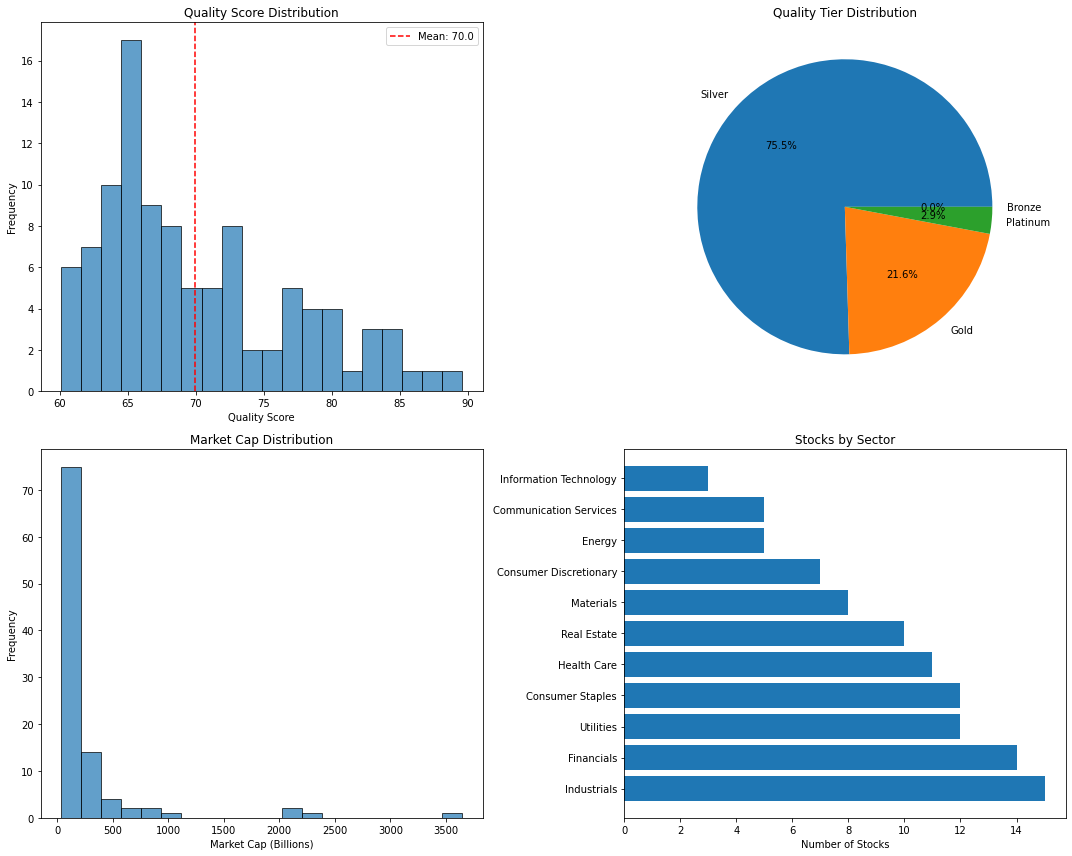

{'basic_stats': {'total_stocks': 102,
  'avg_quality_score': np.float64(69.95282549963729),
  'median_quality_score': np.float64(67.97057191433518),
  'std_quality_score': np.float64(7.178185626068931),
  'min_quality_score': np.float64(60.086833096768814),
  'max_quality_score': np.float64(89.62298805815612)},
 'tier_analysis': {'counts': {'Silver': 77,
   'Gold': 22,
   'Platinum': 3,
   'Bronze': 0},
  'percentages': {'Silver': 75.49019607843137,
   'Gold': 21.568627450980394,
   'Platinum': 2.941176470588235,
   'Bronze': 0.0}},
 'component_analysis': {'mcap_score': {'mean': np.float64(28.87129194095118),
   'std': np.float64(4.596342668735435)},
  'vol_score': {'mean': np.float64(21.556070704143732),
   'std': np.float64(6.36090519714988)},
  'liquidity_score': {'mean': np.float64(16.497881109114957),
   'std': np.float64(2.626481524991677)},
  'sector_balance_score': {'mean': np.float64(3.027581745427421),
   'std': np.float64(3.0961672554367468)}},
 'sector_analysis': {'mean': {

In [15]:
analyzer.analyze_quality_distribution()

In [16]:
analyzer.analyze_sector_concentration()

🚀 GENERATING LUMINA CORE PORTFOLIO
✅ Loading cached Lumina portfolio...

✅ LUMINA CORE PORTFOLIO SUMMARY
📊 Total Stocks: 102
🏆 Avg Quality Score: 70.0/100

🥇 Quality Distribution:
   Platinum: 3 stocks (2.9%)
   Gold: 22 stocks (21.6%)
   Silver: 77 stocks (75.5%)

🏭 Sector Allocation:
   Communication Services: 5.0 stocks (18.8%)
   Financials: 14.0 stocks (16.9%)
   Information Technology: 3.0 stocks (14.9%)
   Consumer Discretionary: 7.0 stocks (12.2%)
   Consumer Staples: 12.0 stocks (9.9%)
   Health Care: 11.0 stocks (9.4%)
   Industrials: 15.0 stocks (7.2%)
   Energy: 5.0 stocks (3.5%)
   Utilities: 12.0 stocks (2.6%)
   Real Estate: 10.0 stocks (2.4%)
   Materials: 8.0 stocks (2.3%)

🏭 SECTOR CONCENTRATION ANALYSIS
📊 Sector Breakdown:
                        stock_count  total_market_cap  avg_market_cap  avg_quality_score  quality_std  sector_weight  stock_concentration
GICS Sector                                                                                                   

,stock_count,total_market_cap,avg_market_cap,avg_quality_score,quality_std,sector_weight,stock_concentration
GICS Sector,,,,,,,
Communication Services,5,5.283388e+12,1.056678e+12,63.306,2.360,0.091,0.049020
Financials,14,4.749668e+12,3.392620e+11,66.707,5.312,0.082,0.137255
Information Technology,3,4.189005e+12,1.396335e+12,68.683,3.204,0.072,0.029412
Consumer Discretionary,7,3.444257e+12,4.920368e+11,70.727,7.136,0.059,0.068627
Consumer Staples,12,2.774690e+12,2.312241e+11,75.233,6.345,0.048,0.117647
Health Care,11,2.658877e+12,2.417161e+11,67.543,6.728,0.046,0.107843
Industrials,15,2.014213e+12,1.342809e+11,66.721,4.136,0.035,0.147059
Energy,5,9.896681e+11,1.979336e+11,70.549,6.809,0.017,0.049020
Real Estate,10,6.776718e+11,6.776718e+10,73.304,7.710,0.012,0.098039


In [22]:
def get_portfolio_with_quality_scores(lumina_engine, include_components=True):
    """
    Get final portfolio DataFrame with quality scores and optional component breakdown
    
    Args:
        engine: Your LuminaCoreEngine instance
        include_components: Whether to include individual score components
    
    Returns:
        DataFrame with stocks and their quality information
    """
    
    # Generate the portfolio (uses cache if available)
    portfolio_df = lumina_engine.generate_lumina_portfolio()
    
    # Select core columns
    core_columns = [
        'Symbol', 
        'Security', 
        'GICS Sector',
        'market_cap',
        'quality_score',
        'quality_tier'
    ]
    
    # Optional: include score components
    component_columns = [
        'mcap_score',
        'vol_score', 
        'liquidity_score',
        'sector_balance_score',
        'volatility'
    ]
    
    if include_components:
        # Check which component columns actually exist
        available_components = [col for col in component_columns if col in portfolio_df.columns]
        selected_columns = core_columns + available_components
    else:
        selected_columns = core_columns
    
    # Create clean DataFrame
    result_df = portfolio_df[selected_columns].copy()
    
    # Add some calculated fields for easier analysis
    result_df['market_cap_billions'] = result_df['market_cap'] / 1e9
    result_df['quality_rank'] = result_df['quality_score'].rank(ascending=False, method='min').astype(int)
    
    # Sort by quality score (highest first)
    result_df = result_df.sort_values('quality_score', ascending=False).reset_index(drop=True)
    
    return result_df

def get_quality_score_summary(engine):
    """
    Get a summary of quality score distribution
    """
    portfolio_df = engine.generate_lumina_portfolio()
    
    summary = {
        'total_stocks': len(portfolio_df),
        'avg_quality_score': portfolio_df['quality_score'].mean(),
        'median_quality_score': portfolio_df['quality_score'].median(),
        'min_quality_score': portfolio_df['quality_score'].min(),
        'max_quality_score': portfolio_df['quality_score'].max(),
        'std_quality_score': portfolio_df['quality_score'].std()
    }
    
    return summary

In [25]:


# Usage example:
if __name__ == "__main__":
    # Assuming you have your engine instance ready
    # engine = LuminaCoreEngine(client)
    
    # Get portfolio with quality scores
    portfolio_quality_df = get_portfolio_with_quality_scores(lumina_engine, include_components=True)
    
    # Display basic info
    print(f"Portfolio has {len(portfolio_quality_df)} stocks")
    print(f"Quality score range: {portfolio_quality_df['quality_score'].min():.1f} - {portfolio_quality_df['quality_score'].max():.1f}")
    
    # Show top 10 stocks
    print("\nTop 10 Stocks by Quality Score:")
    print(portfolio_quality_df[['Symbol', 'Security', 'GICS Sector', 'quality_score', 'quality_tier']].head(10))
    
    # Save to CSV if desired
    # portfolio_quality_df.to_csv('lumina_portfolio_quality_scores.csv', index=False)
    
    # Or get just the summary
    summary = get_quality_score_summary(lumina_engine)
    print(f"\nQuality Score Summary:")
    for key, value in summary.items():
        print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")

🚀 GENERATING LUMINA CORE PORTFOLIO
✅ Loading cached Lumina portfolio...

✅ LUMINA CORE PORTFOLIO SUMMARY
📊 Total Stocks: 102
🏆 Avg Quality Score: 70.0/100

🥇 Quality Distribution:
   Platinum: 3 stocks (2.9%)
   Gold: 22 stocks (21.6%)
   Silver: 77 stocks (75.5%)

🏭 Sector Allocation:
   Communication Services: 5.0 stocks (18.8%)
   Financials: 14.0 stocks (16.9%)
   Information Technology: 3.0 stocks (14.9%)
   Consumer Discretionary: 7.0 stocks (12.2%)
   Consumer Staples: 12.0 stocks (9.9%)
   Health Care: 11.0 stocks (9.4%)
   Industrials: 15.0 stocks (7.2%)
   Energy: 5.0 stocks (3.5%)
   Utilities: 12.0 stocks (2.6%)
   Real Estate: 10.0 stocks (2.4%)
   Materials: 8.0 stocks (2.3%)
Portfolio has 102 stocks
Quality score range: 60.1 - 89.6

Top 10 Stocks by Quality Score:
  Symbol                 Security       GICS Sector  quality_score  \
0     SO         Southern Company         Utilities      89.622988   
1    LIN                Linde plc         Materials      87.036651   


In [28]:
result_df = get_portfolio_with_quality_scores(lumina_engine, include_components=True)

🚀 GENERATING LUMINA CORE PORTFOLIO
✅ Loading cached Lumina portfolio...

✅ LUMINA CORE PORTFOLIO SUMMARY
📊 Total Stocks: 102
🏆 Avg Quality Score: 70.0/100

🥇 Quality Distribution:
   Platinum: 3 stocks (2.9%)
   Gold: 22 stocks (21.6%)
   Silver: 77 stocks (75.5%)

🏭 Sector Allocation:
   Communication Services: 5.0 stocks (18.8%)
   Financials: 14.0 stocks (16.9%)
   Information Technology: 3.0 stocks (14.9%)
   Consumer Discretionary: 7.0 stocks (12.2%)
   Consumer Staples: 12.0 stocks (9.9%)
   Health Care: 11.0 stocks (9.4%)
   Industrials: 15.0 stocks (7.2%)
   Energy: 5.0 stocks (3.5%)
   Utilities: 12.0 stocks (2.6%)
   Real Estate: 10.0 stocks (2.4%)
   Materials: 8.0 stocks (2.3%)


In [1]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(result_df[['Symbol', 'Security', 'quality_score', 'mcap_score', 'vol_score', 'liquidity_score', 'sector_balance']])

NameError: name 'pd' is not defined